In [1]:
# Based on WaveNet: https://arxiv.org/abs/1609.03499

# 1) Data Preparation

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!wget https://raw.githubusercontent.com/Paradox3333/0-to-transformers/master/names.txt

--2024-09-17 16:28:59--  https://raw.githubusercontent.com/Paradox3333/Transformers-from-scratch/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.9’

names.txt.9         100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2024-09-17 16:28:59 (5.96 MB/s) - ‘names.txt.9’ saved [228145/228145]



In [4]:
# Read in all the words:
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [5]:
# Build the vocabulary of characters and mappings to/from integers:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# Shuffle up the words:
import random
random.seed(42)
random.shuffle(words)

In [7]:
# Build the dataset:
block_size = 8 # Context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # Crop and append.

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [8]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


# 2) Neural Net Setup

In [9]:
torch.manual_seed(42); # Seed rng for reproducibility.

In [ ]:
# Near copy paste of the layers we have developed in Part 3.

# -----------------------------------------------------------------------------------------------
class Linear:

  def __init__(self, fan_in: int, fan_out: int, bias: bool=True) -> None:
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # Kaiming init.
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x: torch.tensor) -> torch.tensor:
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self) -> list:
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim: int, eps: float=1e-5, momentum: float=0.1) -> None:
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # Parameters (trained with backprop):
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # Buffers (trained with a running 'momentum update'):
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x: torch.tensor) -> torch.tensor:
    # Calculate the forward pass:
    if self.training:
      xmean = x.mean(0, keepdim=True) # Batch mean.
      xvar = x.var(0, keepdim=True) # Batch variance.
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # Normalize to unit variance.
    self.out = self.gamma * xhat + self.beta
    # Update the buffers:
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self) -> list:
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x: torch.tensor):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  def __init__(self, num_embeddings: int, embedding_dim: int):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX: torch.tensor) -> torch.tensor:
    self.out = self.weight[IX]
    return self.out

  def parameters(self) -> list:
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class Flatten:  # Concatenation class.
  def __call__(self, x: torch.tensor) -> torch.tensor:
    self.out = x.view(x.shape[0], -1)
    return self.out

  def parameters(self) -> list:
    return[]

# -----------------------------------------------------------------------------------------------
class Sequential: # Container class.
  def __init__(self, layers: list) -> None:
    self.layers = layers

  def __call__(self, x: torch.tensor) -> torch.tensor:
    for layer in self.layers:
      x = layer(x)

    self.out = x
    return self.out

  def parameters(self):
    # Get parameters of all layers and stretch them out into one list.
    return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
n_embd = 10
n_hidden = 200

# C = torch.randn((vocab_size, n_embd))       # Substituted for class.

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])
# Parameter init:
with torch.no_grad():
  model.layers[-1].weight *= 0.1  # Last layer make less confident.

# parameters = [C] + [p for layer in layers for p in layer.parameters()]
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))  # Number of parameters in total.
for p in parameters:
  p.requires_grad = True

22097


In [12]:
# Inspection:

ix = torch.randint(0, Xtr.shape[0], (4,)) # Use a batch of only 4 samples for illustration.
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(f'{Xb.shape = }, \n\n{Xb =}')

Xb.shape = torch.Size([4, 8]), 

Xb =tensor([[ 0,  0,  0,  0,  0,  0, 12, 15],
        [ 0,  0,  0,  0,  0,  0, 20,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 11]])


In [13]:
model.layers[0].out.shape # Output of Embedding layer.

torch.Size([4, 8, 10])

In [14]:
model.layers[1].out.shape # Output of Flatten layer.

torch.Size([4, 80])

In [15]:
model.layers[2].out.shape # Output of Linear layer.

torch.Size([4, 200])

In [16]:
# So this is essentially what is happening in the first Linear layer:

# Input: 8 characters
# (1 2 3 4 5 6 7 8)

(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 200])

In [ ]:
# But in pytorch we can also introduce more dimensions and do:

(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

# So, instead, we essentially want the model to process 2 characters in the first layer,
# then fuse the bigrams and process two of them, and so on, as shown in the WaveNet below:
# (0 1) (2 3) (4 5) (6 7)

# This means that we want the Flatten layer to reshape into a (4, 4, 20) tensor instead of a (4, 80) tensor.
# This effectively introduces another batch dimension.
# The 1st dimension corresponds to the number of samples "N" in a processed batch.
# The 2nd dimension corresponds to the bigram batch.
# (1 batch = 2 samples, so 4 batches = 8 samples, which is the context length, "block_size").
# The 3rd dimension corresponds to the stacked embeddings per bigram. (20, because 2 chars * 10 embeddings).

# To do this, we grab the characters at even indices and concatenate them with the ones with odd indices:

# We have (0, 1, 2, 3, 4, 5, 6, 7) characters by index.
# We arrange the first dimension as: (0, 2, 4, 6)
# And the second as:                 (1, 3, 5, 7)
# And concatenate them along the 2nd dimension (remember the dimension indexing starts from 0).
# This is the explicit way to do it.
# But it turns out that we can also call .view(4, 4, 20) and achieve the same result in this case,
# though this can be checked for correctness.

# Additionally, this means we need to change the linear layer as well to expect 20 inputs instead of a full 80 at a time.

# This way, the network does not try to pack too much information into a single layer.

torch.Size([4, 4, 200])

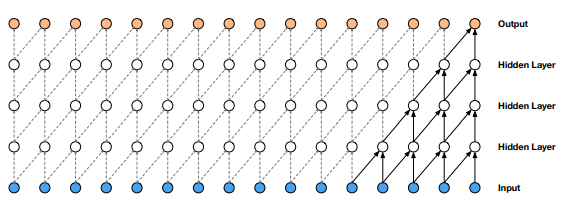

In [19]:
# Same optimization as last time.
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # Minibatch construct:
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X, Y.

    # Forward pass
    # emb = C[Xb] # embed the characters into vectors.
    # x = emb.view(emb.shape[0], -1) # concatenate the vectors (input).
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # Loss function.

    # Backward pass:
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update: simple SGD:
    lr = 0.1 if i < 150000 else 0.01 # Step learning rate decay.
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats:
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # break

      0/ 200000: 3.2759
  10000/ 200000: 2.2820
  20000/ 200000: 1.9815
  30000/ 200000: 2.2905
  40000/ 200000: 1.6680
  50000/ 200000: 2.1309
  60000/ 200000: 2.0995
  70000/ 200000: 1.9837
  80000/ 200000: 2.3809
  90000/ 200000: 1.9384
 100000/ 200000: 2.2440
 110000/ 200000: 2.3459
 120000/ 200000: 1.8382
 130000/ 200000: 1.6216
 140000/ 200000: 1.8790
 150000/ 200000: 2.3631
 160000/ 200000: 2.0177
 170000/ 200000: 1.6581
 180000/ 200000: 1.7976
 190000/ 200000: 2.0361


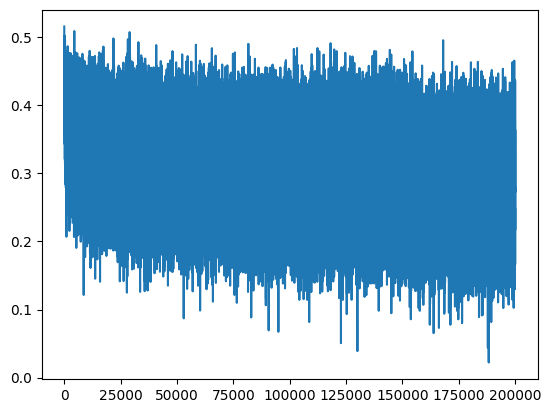

In [20]:
plt.plot(lossi)

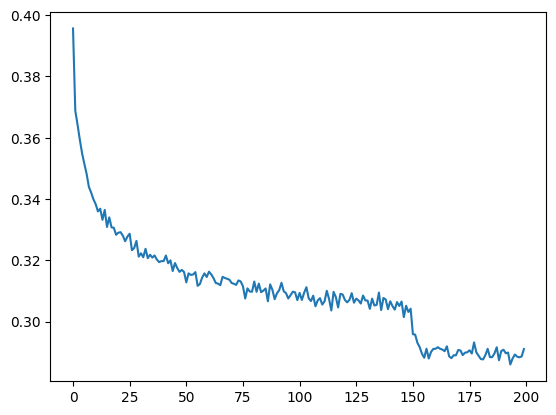

In [21]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [22]:
# Put layer in inference mode (important for BatchNorm especially):

for layer in model.layers:
  layer.training = False

In [23]:
# Evaluate the loss:
@torch.no_grad() # This decorator disables gradient tracking inside pytorch.
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]

  logits = model(x)

  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9187854528427124
val 2.028489351272583


In [24]:
# Sample from the model:
for _ in range(20):

    out = []
    context = [0] * block_size  # Initialize with all zeros.
    while True:
        # Forward pass the neural net:

        # emb = C[torch.tensor([context])]  # (1, block_size, n_embd).
        # x = emb.view(emb.shape[0], -1)  # Concatenate the vectors.

        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # Sample from the distribution:
        ix = torch.multinomial(probs, num_samples=1).item()
        # Shift the context window and track the samples:
        context = context[1:] + [ix]
        out.append(ix)
        # If we sample the special '.' token, break.
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))  # Decode and print the generated word.


taleigh.
adeyla.
ala.
moshay.
hiham.
eilin.
alivi.
bridte.
haram.
andramara.
raylei.
hagollera.
kylan.
grinli.
ryek.
shailan.
stefuph.
anthid.
shylei.
tijon.


# 3) WaveNet Setup through Multiple Batch Dimensions


In [56]:
torch.manual_seed(42); # Seed rng for reproducibility.

In [57]:
# Near copy paste of the layers we have developed in Part 3.

# -----------------------------------------------------------------------------------------------
class Linear:

  def __init__(self, fan_in: int, fan_out: int, bias: bool=True) -> None:
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # Note: kaiming init.
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x: torch.tensor) -> torch.tensor:
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self) -> list:
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim: int, eps: float=1e-5, momentum: float=0.1) -> None:
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # Parameters (trained with backprop):
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # Buffers (trained with a running 'momentum update'):
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x: torch.tensor) -> torch.tensor:
    # Calculate the forward pass:
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0, 1)    # We are dealing with a sequence, where each feature has multiple values across different sequence steps and different samples in the batch.
                        # The goal of batch normalization is to normalize each feature. So, to normalize each feature across all samples and all time steps, you need to
                        # collapse both batch dimensions. Remember that the second dimension is the bigrams of 1 sample of the batch, but it's still 1 sample!
      xmean = x.mean(dim, keepdim=True) # Batch mean.
      xvar = x.var(dim, keepdim=True) # Batch variance.
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # Normalize to unit variance.
    self.out = self.gamma * xhat + self.beta
    # Update the buffers:
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self) -> list:
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x: torch.tensor):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  def __init__(self, num_embeddings: int, embedding_dim: int):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX: torch.tensor) -> torch.tensor:
    self.out = self.weight[IX]
    return self.out

  def parameters(self) -> list:
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:  # Concatenation class.
  def __init__(self, n: int) -> None:
      self.n = n  # With "n" being the number if consecutive elements we want (e.g. a bigram is 2 consecutive chars).

  def __call__(self, x: torch.tensor) -> torch.tensor:
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)  # Remember "C" corresponds to the embedding dimension (e.g if our embedding space is 10D and n=2, we get 20 as the last dimension from the reshaping),
                                        # and the second dimension is reduced as a result (e.g from 8 chars to 8/2=4 bigrams). "//" corresponds to integer division.
    if x.shape[1] == 1: # Edge case when n = all elements (e.g if n=8, we are concatenating everything but we would get a leftover dimension from the reshaping result (N, 1, 80)).
      x = x.squeeze(1)  # Take out the 2nd useless dimension, returning (B, C*n)

    self.out = x
    return self.out

  def parameters(self) -> list:
    return[]

# -----------------------------------------------------------------------------------------------
class Sequential: # Container class.
  def __init__(self, layers: list) -> None:
    self.layers = layers

  def __call__(self, x: torch.tensor) -> torch.tensor:
    for layer in self.layers:
      x = layer(x)

    self.out = x
    return self.out

  def parameters(self):
    # Get parameters of all layers and stretch them out into one list.
    return [p for layer in self.layers for p in layer.parameters()]

In [59]:
# Chosen so total parameters is roughly equal to the previous network:
n_embd = 10 # The dimensionality of the character embedding vectors.
n_hidden = 68 # The number of neurons in the hidden layer of the MLP.

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])
# Parameter init:
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # Last layer make less confident.

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # Number of parameters in total.
for p in parameters:
  p.requires_grad = True

22397


In [60]:
# Shapes inspection:

# for layer in model.layers:
#   print(layer.__class__.__name__, ':', tuple(layer.out.shape))

In [61]:
# Same optimization as last time.
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # Minibatch construct:
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X, Y.

    # Forward pass
    # emb = C[Xb] # embed the characters into vectors.
    # x = emb.view(emb.shape[0], -1) # concatenate the vectors (input).
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # Loss function.

    # Backward pass:
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update: simple SGD:
    lr = 0.1 if i < 150000 else 0.01 # Step learning rate decay.
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats:
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # break

      0/ 200000: 3.3142
  10000/ 200000: 2.2096
  20000/ 200000: 2.1495
  30000/ 200000: 2.1232
  40000/ 200000: 1.9629
  50000/ 200000: 2.4183
  60000/ 200000: 1.9633
  70000/ 200000: 1.8960
  80000/ 200000: 2.1884
  90000/ 200000: 1.8161
 100000/ 200000: 1.5931
 110000/ 200000: 2.3607
 120000/ 200000: 2.3670
 130000/ 200000: 1.9098
 140000/ 200000: 2.2285
 150000/ 200000: 1.7118
 160000/ 200000: 1.8517
 170000/ 200000: 1.9997
 180000/ 200000: 2.1043
 190000/ 200000: 1.6968


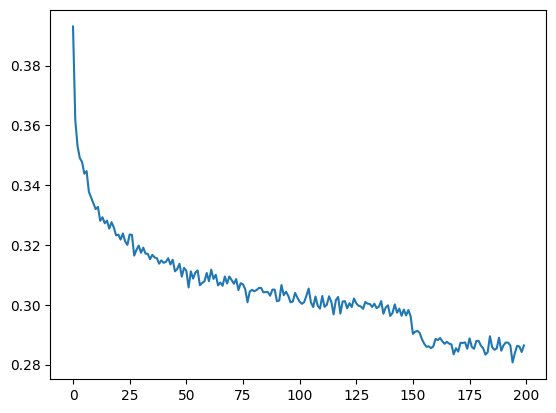

In [62]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [63]:
# Put layer in inference mode (important for BatchNorm especially):

for layer in model.layers:
  layer.training = False

In [64]:
# Evaluate the loss:
@torch.no_grad() # This decorator disables gradient tracking inside pytorch.
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]

  logits = model(x)

  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.911011815071106
val 2.020193338394165


In [65]:
# Sample from the model:
for _ in range(20):

    out = []
    context = [0] * block_size  # Initialize with all zeros.
    while True:
        # Forward pass the neural net:

        # emb = C[torch.tensor([context])]  # (1, block_size, n_embd).
        # x = emb.view(emb.shape[0], -1)  # Concatenate the vectors.

        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # Sample from the distribution:
        ix = torch.multinomial(probs, num_samples=1).item()
        # Shift the context window and track the samples:
        context = context[1:] + [ix]
        out.append(ix)
        # If we sample the special '.' token, break.
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))  # Decode and print the generated word.


lansan.
dyluwa.
jenel.
gisen.
fynnton.
nocah.
kamore.
elizan.
audlyn.
cadysin.
kimber.
synnabe.
zhry.
jkeer.
shiito.
noraandro.
aaithel.
quiam.
braeon.
darielli.


# 4) Performance log
- Original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- Context: 3 -> 8 (22K params): train 1.918, val 2.027
- Fix batchnorm stats computation: train 1.912, val 2.022

# 5) Convolution Analogy

In [ ]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [ ]:
# forward a single example:
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [ ]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

In [ ]:
# convolution is a "for loop"
# allows us to forward Linear layers efficiently over space by "sliding" over an input sequence instead of splitting it into multiple examples each requiring a pass through the NN.

# 6) 3D vs 2D Indexing

In [79]:
# Visualization of torch.mean with a tuple of dimensions (as applied in the BatchNorm above)
temp = torch.tensor([[[1.0, 2.0],
                   [3.0, 4.0]],

                  [[5.0, 6.0],
                   [7.0, 8.0]]])

# TIP: Visualize the collapsing dimensions and how the result should look like dimension-wise after the operation.
# Collapsing layers (dim 0) and rows (dim 1), meaning the result has to be (1,1,2):
print(f'{temp.mean((0,1), keepdim=True).shape = }, \n\n{temp.mean((0,1), keepdim=True) = }, \n\n{(1.0 + 3.0 + 5.0 + 7.0)/4 = }, \n\n{(2.0 + 4.0 + 6.0 + 8.0)/4 = }')
# ...
print(f'\n\n{temp.mean((0,2), keepdim=True).shape = }, \n\n{temp.mean((0,2), keepdim=True) = }, \n\n{(1.0 + 2.0 + 5.0 + 6.0)/4 = }, \n\n{(3.0 + 4.0 + 7.0 + 8.0)/4 = }')
# ...
print(f'\n\n{temp.mean((1,2), keepdim=True).shape = }, \n\n{temp.mean((1,2), keepdim=True) = }, \n\n{(1.0 + 2.0 + 3.0 + 4.0)/4 = }, \n\n{(5.0 + 6.0 + 7.0 + 8.0)/4 = }')

# NOTE: The first dimension in 3D is the "horizontal" layer dimension. Layers are stacked! Or you can think of it as TWO different tensors part of a single
#       unit, one with index (0,:,:) and the other with index (1,:,:).

temp.mean((0,1), keepdim=True).shape = torch.Size([1, 1, 2]), 

temp.mean((0,1), keepdim=True) = tensor([[[4., 5.]]]), 

(1.0 + 3.0 + 5.0 + 7.0)/4 = 4.0, 

(2.0 + 4.0 + 6.0 + 8.0)/4 = 5.0


temp.mean((0,2), keepdim=True).shape = torch.Size([1, 2, 1]), 

temp.mean((0,2), keepdim=True) = tensor([[[3.5000],
         [5.5000]]]), 

(1.0 + 2.0 + 5.0 + 6.0)/4 = 3.5, 

(3.0 + 4.0 + 7.0 + 8.0)/4 = 5.5


temp.mean((1,2), keepdim=True).shape = torch.Size([2, 1, 1]), 

temp.mean((1,2), keepdim=True) = tensor([[[2.5000]],

        [[6.5000]]]), 

(1.0 + 2.0 + 3.0 + 4.0)/4 = 2.5, 

(5.0 + 6.0 + 7.0 + 8.0)/4 = 6.5


In [77]:
print(f'temp[0, :, :]: Bottom Layer!\n\n{temp[0, :, :]}, \n\ntemp[1, :, :]: Top Layer!\n\n{temp[1, :, :]}')


temp[0, :, :]: Bottom Layer!

tensor([[1., 2.],
        [3., 4.]]), 

temp[1, :, :]: Top Layer!

tensor([[5., 6.],
        [7., 8.]])


In [78]:
print(f'temp[0, 0, :]: 1st Row of Bottom Layer!\n\n{temp[0, 0, :]}, \n\ntemp[1, 0, :]: 1st Row of Top Layer!\n\n{temp[1, 0, :]}')


temp[0, 0, :]: 1st Row of Bottom Layer!

tensor([1., 2.]), 

temp[1, 0, :]: 1st Row of Top Layer!

tensor([5., 6.])


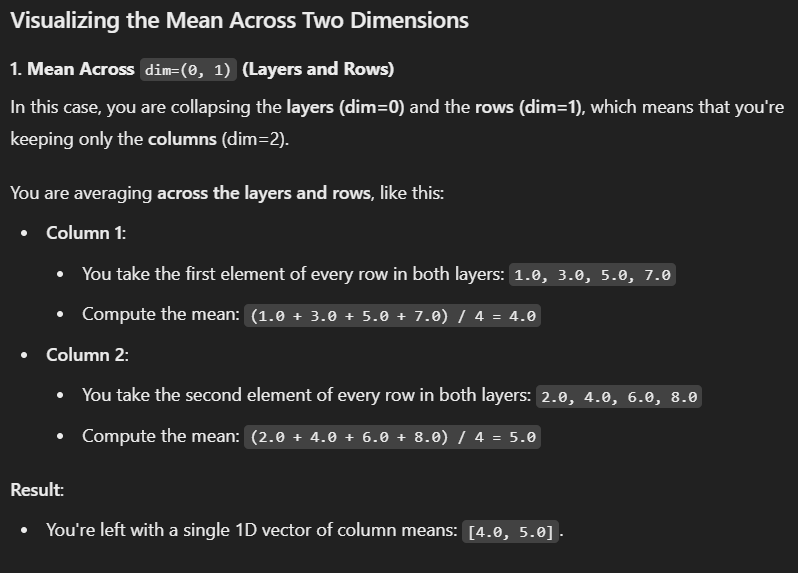

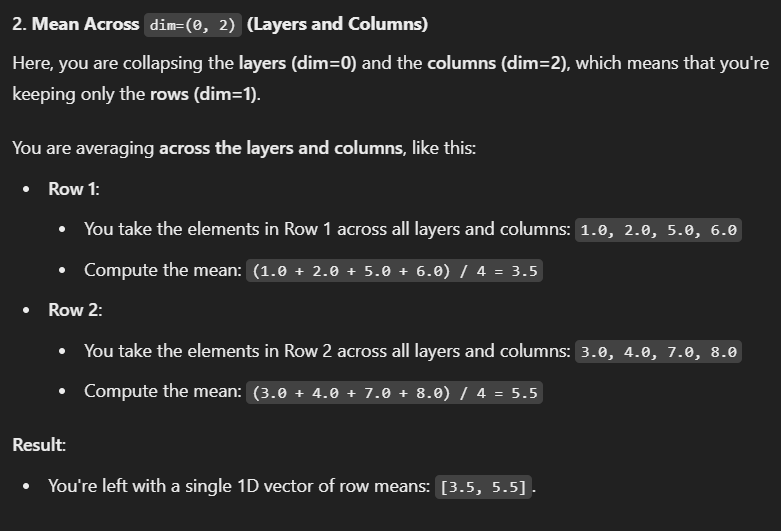

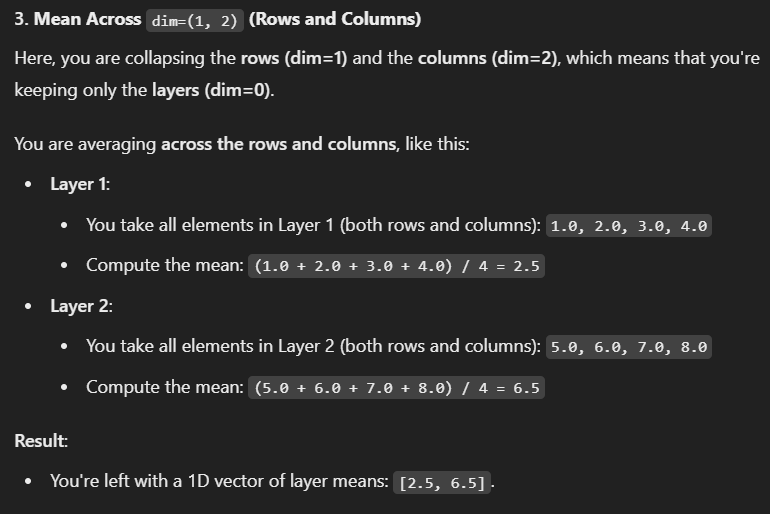